# Text to SQL Generation for BigQuery using Vertex AI PALM API

One of LLM capability to improve developer productivity is generating SQL query based on natual language prompting. This feature enabale various use case in analyzing data from data warehouse in BigQuery. Some of possible use case are:
- Data analyst chatbot. Enable QnA directly between end user with their business data via natural language.
- Dashboard generator automation. An automatic dashboard that able to create insights from data in data warehouse.
- Data analyst asistant. An assistant to data analyst and BI developer in creating, validating, and analyzing SQL query.



In this tutorial, we will waltkthrough various prompting techniques for LLM to generate SQL statement for Google BigQuery. We will be using text-bison@001 model from Vertex AI PALM API.


# Install Vertex AI SDK and Other Packages
We will be using Vertex AI SDK and some Python packages such as Pandas and Plotly.

In [1]:
!pip install google-cloud-aiplatform pandas google-api-python-client langchain

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


We will be using [Python Client fo BigQuery](https://cloud.google.com/python/docs/reference/bigquery/latest) to connect directly to BigQuery's dataset and table.  

In [2]:
# import required packages
import vertexai
import pandas as pd
from vertexai.language_models import TextGenerationModel
from google.cloud import aiplatform
from google.cloud import bigquery
import os

from IPython.display import Markdown as md


2023-12-11 14:50:55.919694: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 14:50:55.921969: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 14:50:55.976124: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-11 14:50:55.977074: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 14:50:56.826647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Specify project detail and location

In [3]:
#please delete rabbitconsulting dataset in BigQuery if exists (optional)
#please click Kernel-Restart Kernels and Clear All Outputs, run the command again from top (optional)

In [4]:
#change projectid as required

project_id = "work-mylab-machinelearning"  # @param {type:"string"}
location = "us-central1"  # @param {type:"string"}
dataset_id = 'rabbitconsulting' # @param {type:"string"}


In [5]:
# authenticate to google cloud account

# use the following auth method ONLY if you use google colab

#from google.colab import auth as google_auth
#google_auth.authenticate_user()

## Initiate Vertex AI LLM and BigQuery client

In [6]:
vertexai.init(project=project_id, location=location)
generation_model = TextGenerationModel.from_pretrained(model_name="text-bison@001")

bq_client = bigquery.Client(project=project_id, location=location)

# Load Sample Dataset to BigQuery

In [7]:
#create bigquery dataset

#define fullt qualified dataset name: "projectid.datasetid"
dataset_id = "{}.{}".format(project_id, dataset_id)

#create BigQuery dataset
dataset = bq_client.create_dataset(dataset_id, timeout=30)
print("Created dataset {}.{}".format(bq_client.project, dataset.dataset_id))

Created dataset work-mylab-machinelearning.rabbitconsulting


In [8]:
#get csv file from repository

customerfile= 'https://raw.githubusercontent.com/mchoirul/genai-code/main/sampledata/rabbit_customer_dummy.csv'
ordertransactionfile = 'https://raw.githubusercontent.com/mchoirul/genai-code/main/sampledata/rabbit-customer-transaction.csv'
surveyfile = 'https://raw.githubusercontent.com/mchoirul/genai-code/main/sampledata/rabbit-satisfactionsurvey.csv'

In [9]:
#create function to import csv to BigQuery
def import_csv_to_bq (filepath, table_id):

  job_config = bigquery.LoadJobConfig(
      source_format=bigquery.SourceFormat.CSV, skip_leading_rows=1, autodetect=True,
          write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE )

  df = pd.read_csv(filepath, delimiter=',', )
  load_job = bq_client.load_table_from_dataframe(dataframe=df,
                                          destination=table_id,
                                            job_config=job_config)  # Make an API request.


  load_job.result()  # Waits for the job to complete.

  table = bq_client.get_table(table_id)  # Make an API request.
  print(
      "Loaded {} rows and {} columns to {}".format(
          table.num_rows, len(table.schema), table_id
      )
)

In [10]:
#import customer csv
tablename = 'customerdata'
table_id = "{}.{}".format(dataset_id, tablename) #fully qualified table name
print (table_id)

import_csv_to_bq(customerfile, table_id)

#preview imported data
bq_client.query("SELECT * FROM "+ table_id).to_dataframe().head()

work-mylab-machinelearning.rabbitconsulting.customerdata
Loaded 58 rows and 7 columns to work-mylab-machinelearning.rabbitconsulting.customerdata


,custid,custname,dateofbirth,city_address,nationality,memberstatus,education
0,31,Mickey Mouse,1950-01-01,Jakarta,Indonesia,YES,Bachelor
1,8,Iron Man,1960-03-03,Pontianak,Indonesia,NO,Doctorate
2,20,Beast,1960-03-03,Jambi,Indonesia,NO,Doctorate
3,38,Dale,1960-03-03,Pontianak,Indonesia,NO,Doctorate
4,50,Max Goof,1960-03-03,Jambi,Indonesia,NO,Doctorate


In [11]:
#import order transaction to BigQuery
tablename = 'ordertransaction'
table_id = "{}.{}".format(dataset_id, tablename) #fully qualified table name
print (table_id)

import_csv_to_bq(ordertransactionfile, table_id)

#preview imported data
bq_client.query("SELECT * FROM "+ table_id).to_dataframe().head()

work-mylab-machinelearning.rabbitconsulting.ordertransaction
Loaded 279 rows and 7 columns to work-mylab-machinelearning.rabbitconsulting.ordertransaction


,transactionid,custid,transactsitelocation,transactiondate,servicecategory,transactionamount,servingconsultant
0,TX3008,27,Surabaya,2022-01-08,Eye Care,800000,Ema
1,TX3028,33,Bandung,2022-01-28,Eye Care,800000,Ema
2,TX3040,21,Bandung,2022-02-10,Covid Test,2900000,Ema
3,TX1004,12,Bandung,2023-03-11,Consultation,500000,Ema
4,TX1024,12,Bandung,2023-03-31,Consultation,500000,Ema


In [12]:
#import survey data to BigQuery
tablename = 'satisfactionsurvey'
table_id = "{}.{}".format(dataset_id, tablename) #fully qualified table name
print (table_id)

import_csv_to_bq(surveyfile, table_id)

#preview imported data
bq_client.query("SELECT * FROM "+ table_id).to_dataframe().head()

work-mylab-machinelearning.rabbitconsulting.satisfactionsurvey
Loaded 279 rows and 2 columns to work-mylab-machinelearning.rabbitconsulting.satisfactionsurvey


,transactionid,surveyscore
0,TX3070,61
1,TX3091,61
2,TX3093,61
3,TX5147,61
4,TX3027,62


# Create Prompt for Text to SQL

In [13]:
#create text string for prompt input to the model
#define prompt engineering to generate SQL query

#important: change work-mylab-machinelearning to your projectname

#always limit query result to 50 rows as default row number, to save query cost
def custom_prompt(question, top_k=50):
    # question: user question
    # top_k: limit number of rows returned - default is 50

    prompt = """
    You are a GoogleSQL expert. This is a task converting text into GoogleSQL statement.
    Use the following information to create a syntactically correct BigQuery query

    Table information:
    Table \"work-mylab-machinelearning.rabbitconsulting.customerdata\" contains customer detail information
    Table \"work-mylab-machinelearning.rabbitconsulting.ordertransaction\" contains detail transaction for each customer
    Table \"work-mylab-machinelearning.rabbitconsulting.satisfactionsurvey\" contains score for satisfaction survey of each transaction

    Table and columns as follows:
    Table \"work-mylab-machinelearning.rabbitconsulting.customerdata\"
    Columns: custid (primary key), custname, dateofbirth, city_address, nationality, memberstatus, education

    Table \"work-mylab-machinelearning.rabbitconsulting.ordertransaction\"
    Columns: transactionid (primary key), custid (foreign key), transactsitelocation, transactiondate, servicecategory, transactionamount, servingconsultant

    Table \"work-mylab-machinelearning.rabbitconsulting.satisfactionsurvey\"
    Columns: transactionid (foreign key), surveyscore


    The join between tables:
    one to many join: work-mylab-machinelearning.rabbitconsulting.customerdata.custid = work-mylab-machinelearning.rabbitconsulting.ordertransaction.custid
    one to many join: work-mylab-machinelearning.rabbitconsulting.ordertransaction.transactionid = work-mylab-machinelearning.rabbitconsulting.satisfactionsurvey.transactionid

    Only use fields from each respecting table. Never use column that does not exists in the table.
    Wrap each column name in backticks (`) to denote them as delimited identifiers.

    Examples:
    question: show average sales for each city when transaction happened in Jan-march 2023
    answer: SELECT `city_address`, AVG(`transactionamount`) AS average_sales FROM work-mylab-machinelearning.rabbitconsulting.`ordertransaction` AS o JOIN work-mylab-machinelearning.rabbitconsulting.`customerdata` AS c ON c.`custid` = o.`custid` WHERE `transactiondate` BETWEEN '2023-01-01' AND '2023-03-31' GROUP BY `city_address`

    question: show average satisfaction score for each consultant
    answer: SELECT `servingconsultant`, AVG(`surveyscore`) AS average_satisfaction_score FROM work-mylab-machinelearning.rabbitconsulting.`ordertransaction` AS o JOIN work-mylab-machinelearning.rabbitconsulting.`satisfactionsurvey` AS s ON o.`transactionid` = s.`transactionid` GROUP BY `servingconsultant`

    question: show total sales, transaction frequency, and average score for each city
    answer: SELECT `city_address`, SUM(`transactionamount`) AS total_sales, COUNT(o.`transactionid`) AS transaction_frequency, AVG(`surveyscore`) AS average_score FROM work-mylab-machinelearning.rabbitconsulting.`customerdata` AS c JOIN work-mylab-machinelearning.rabbitconsulting.`ordertransaction` AS o ON c.`custid` = o.`custid` JOIN work-mylab-machinelearning.rabbitconsulting.`satisfactionsurvey` AS s ON o.`transactionid` = s.`transactionid` GROUP BY `city_address`

    Always limit query using at most """ + str(top_k) + """ results using LIMIT clause.
    If you cannot find the information or not sure, response "I do not have enough data"
    If the answer require DML or DDL statement, reject and response "Command not allowed"
    If the answer require query to INFORMATION_SCHEMA, reject and response "Command not allowed"
    Never make up the answer.

    Let's think step by step

    Create SQL statement from the following question
    question: """ + question

    return prompt

In [14]:
#test prompt text template
myquestion = "show total sales for each city"
custom_prompt(myquestion)

'\n    You are a GoogleSQL expert. This is a task converting text into GoogleSQL statement.\n    Use the following information to create a syntactically correct BigQuery query\n\n    Table information:\n    Table "work-mylab-machinelearning.rabbitconsulting.customerdata" contains customer detail information\n    Table "work-mylab-machinelearning.rabbitconsulting.ordertransaction" contains detail transaction for each customer\n    Table "work-mylab-machinelearning.rabbitconsulting.satisfactionsurvey" contains score for satisfaction survey of each transaction\n\n    Table and columns as follows:\n    Table "work-mylab-machinelearning.rabbitconsulting.customerdata"\n    Columns: custid (primary key), custname, dateofbirth, city_address, nationality, memberstatus, education\n\n    Table "work-mylab-machinelearning.rabbitconsulting.ordertransaction"\n    Columns: transactionid (primary key), custid (foreign key), transactsitelocation, transactiondate, servicecategory, transactionamount, ser

In [15]:
#using palm api from scratch to generate sql query

#define function to call PALM LLM model
def create_query(question, top_k=50):

    #generate custom prompt
    q = custom_prompt(question, top_k)

    generated_query = generation_model.predict(
        prompt=q,
        max_output_tokens=1024,
        temperature=0.0
        ).text

    return generated_query

In [16]:
#test to generate SQL query #1
create_query("show average sales, order frequency, and average score for each city when order period is between Jan - march 2023, then order by highest sales")

"SELECT `city_address`, SUM(`transactionamount`) AS total_sales, COUNT(o.`transactionid`) AS transaction_frequency, AVG(`surveyscore`) AS average_score FROM work-mylab-machinelearning.rabbitconsulting.`customerdata` AS c JOIN work-mylab-machinelearning.rabbitconsulting.`ordertransaction` AS o ON c.`custid` = o.`custid` JOIN work-mylab-machinelearning.rabbitconsulting.`satisfactionsurvey` AS s ON o.`transactionid` = s.`transactionid` WHERE `transactiondate` BETWEEN '2023-01-01' AND '2023-03-31' GROUP BY `city_address` ORDER BY total_sales DESC LIMIT 50"

In [17]:
#test to generate SQL query #3
create_query("Show 10 orders from Jakarta and Surabaya in the period Jan - March 2023")

"SELECT * FROM work-mylab-machinelearning.rabbitconsulting.`ordertransaction` AS o JOIN work-mylab-machinelearning.rabbitconsulting.`customerdata` AS c ON c.`custid` = o.`custid` WHERE `city_address` IN ('Jakarta', 'Surabaya') AND `transactiondate` BETWEEN '2023-01-01' AND '2023-03-31' LIMIT 10"

In [18]:
#test to generate SQL query #4
#this query is prohibited!
create_query("SELECT * FROM work-mylab-machinelearning.rabbitconsulting.INFORMATION_SCHEMA.COLUMNS WHERE table_name = 'customerdata'")

'Command not allowed'

#Execute Generated SQL to BigQuery

## Create Function to Retrieve BQ Data

In [19]:
#create function to execute generated query to BQ

def bq_qa_llm(userquery, top_k=50):

    query_job = bq_client.query(
                                create_query(userquery, top_k))

    rows = query_job.result()
    return rows.to_dataframe()


In [20]:
#test to generate SQL query & execute to BQ #1
#limit to 10 rows
bq_qa_llm("show average sales, order frequency, and average score for each city when order period is between Jan - march 2023, then order by highest sales", 10)

,city_address,total_sales,transaction_frequency,average_score
0,Manado,9000000,3,88.000000
1,Makassar,8500000,4,79.250000
2,Pontianak,7000000,4,72.000000
3,Bandar Lampung,6500000,3,79.666667
4,Ambon,6500000,4,79.500000
5,Kupang,6200000,3,70.000000
6,Banjarmasin,5500000,4,73.250000
7,Pekanbaru,5500000,3,77.000000
8,Palembang,5500000,4,81.000000
9,Jambi,4000000,3,78.333333


In [21]:
bq_qa_llm("Show top 3 services with the best sales")

,servicecategory,total_sales
0,Covid Test,153300000
1,Skin Care,104000000
2,General Checkup,100700000


In [22]:
bq_qa_llm("display total sales, order frequency, and average survey score for each consultant. sort from highest sales")

,servingconsultant,total_sales,transaction_frequency,average_survey_score
0,Ahmad,134900000,71,80.549296
1,Ema,120700000,69,82.159420
2,Boby,118200000,65,72.815385
3,Rany,114500000,65,76.430769


## Explaining SQL Query in Human Language

In [23]:
#using palm api to explain the logic of sql query
def create_explanation(question, sql_answer):

    explain_prompt="""
            You are an expert data analyst working with python, SQL, and pandas.
            For the SQL query you have just created, explain why you have that ouput and how does it answer the question.

            the original question is: """ + question + """
            your answer in SQL is: """ + sql_answer + """

            Explain how you came up with SQL code for non-technical people without mentioning technical details or mentioning the libraries used?
            Always explain with an easy to understand english language first.

            Explain your response using the following structure:

            Objective: explain the objective by rephrase the original question \n
            Explanation: write your explanation for non technical people. please be concise and simple.
            """

    explanation = generation_model.predict(
        prompt=explain_prompt,
        max_output_tokens=1024,
        temperature=0.1,
        top_k=40,
        top_p=0.8
        ).text

    return explanation

In [24]:
#explain generated SQL Query for non technical person
original_question = "show total orders amount and frequency from jakarta and surabaya in the period Jan - Jun 2023"
sqlanswer = create_query(original_question)
display(md(sqlanswer))

#generate and display explanation
explain_sql = create_explanation(original_question, sqlanswer)
display(md(explain_sql))

SELECT `city_address`, SUM(`transactionamount`) AS total_orders_amount, COUNT(o.`transactionid`) AS transaction_frequency FROM work-mylab-machinelearning.rabbitconsulting.`customerdata` AS c JOIN work-mylab-machinelearning.rabbitconsulting.`ordertransaction` AS o ON c.`custid` = o.`custid` JOIN work-mylab-machinelearning.rabbitconsulting.`satisfactionsurvey` AS s ON o.`transactionid` = s.`transactionid` WHERE `city_address` IN ('Jakarta', 'Surabaya') AND `transactiondate` BETWEEN '2023-01-01' AND '2023-06-30' GROUP BY `city_address` LIMIT 50

Objective: The objective of this query is to find the total orders amount and frequency from Jakarta and Surabaya in the period Jan - Jun 2023.

            Explanation: The query first joins the customerdata, ordertransaction, and satisfactionsurvey tables on the custid column. This ensures that we only get data for customers who have made orders and have completed satisfaction surveys. The query then uses the WHERE clause to filter the results to only include orders from Jakarta and Surabaya in the period Jan - Jun 2023. The query then uses the GROUP BY clause to group the results by city_address. Finally, the query uses the SUM and COUNT functions to calculate the total orders amount and frequency for each city.

# Experimenting with Langchain Agent to do Complex QnA

In [25]:
#using langchain dataframe agent to explain and getting insights from dataframe
from langchain.agents.agent_types import AgentType
from langchain.llms import VertexAI
from langchain.agents.agent_toolkits import create_pandas_dataframe_agent

In [26]:
#create another dataframe and analyze

#get dataframe
df = bq_qa_llm("show order amount, customername, city, and product for period is between Jan - march 2023")

#getting insights from dataframe
agent = create_pandas_dataframe_agent(
    VertexAI(temperature=0.3,
    model_name="text-bison@001"),
    df,
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    max_iterations=6
)

agent.run("provide insights by comparing customer order amounts from each city")



> Entering new  chain...
Thought: I need to group the data by city and calculate the total transaction amount for each city.
Action: python_repl_ast
Action Input: df.groupby('city_address').agg({'transactionamount': 'sum'})
Observation:                 transactionamount
city_address                     
Ambon                     6500000
Bandar Lampung            6500000
Bandung                   3000000
Banjarmasin               5500000
Denpasar                  1000000
Jambi                     4000000
Jayapura                  2000000
Kupang                    6200000
Makassar                  8500000
Manado                    9000000
Mataram                   1500000
Medan                     2500000
Padang                    1500000
Palembang                 5500000
Pekanbaru                 5500000
Pontianak                 7000000
Semarang                  2500000
Surabaya                   500000
Yogyakarta                1000000
Thought:I now know the final answer
Final Answe

'The city with the highest customer order amount is Makassar, with a total of 8500000. The city with the lowest customer order amount is Surabaya, with a total of 50000.'

In [27]:
#another question, using the same dataframe
agent.run("provide sales insights on the best-selling products in each city")



> Entering new  chain...
Thought: I need to group the data by city and service category, and then find the maximum transaction amount for each group.
Action: python_repl_ast
Action Input: df.groupby(['city_address', 'servicecategory'])['transactionamount'].max()
Observation: city_address    servicecategory
Ambon           Consultation        500000
                Covid Test         3000000
                Skin Care          2500000
Bandar Lampung  Consultation       1500000
                Covid Test         3000000
                General Checkup    2000000
Bandung         Covid Test         3000000
Banjarmasin     Consultation        500000
                Covid Test         3000000
                Eye Care           1000000
Denpasar        Eye Care           1000000
Jambi           Consultation       1500000
                General Checkup    2000000
Jayapura        Eye Care           1000000
Kupang          General Checkup    2500000
                Skin Care          2500000
Ma

'The best-selling products in each city are as follows:\n\n- Ambon: Consultation\n- Bandar Lampung: Consultation\n- Bandung: Covid Test\n- Banjarmasin: Eye Care\n- Denpasar: Eye Care\n- Jambi: Consultation\n- Jayapura: Eye Care\n- Kupang: General Checkup\n- Makassar: Consultation\n- Manado: Covid Test\n- Mataram: Skin Care\n- Medan: General Checkup\n- Padang: Skin Care\n- Palembang: Eye Care\n- Pekanbaru: Eye Care\n- Pontianak: Eye Care\n- Semarang: General Check'



> Entering new  chain...
Thought: I need to group the dataframe by service category and calculate the total transaction amount for each category. Then I can use the matplotlib library to create a bar chart.
Action: python_repl_ast
Action Input: df.groupby('servicecategory').agg({'transactionamount': 'sum'}).plot(kind='bar')
Observation: Axes(0.125,0.11;0.775x0.77)
Thought:I now know the final answer
Final Answer:

> Finished chain.


''

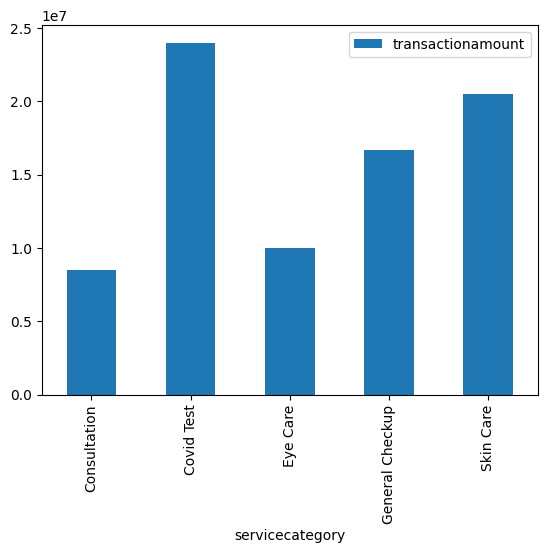

In [28]:
# generate visualization using agent
agent.run("display total sales for each product in a bar chart")

# Further References
- https://medium.com/google-cloud/architectural-patterns-for-text-to-sql-leveraging-llms-for-enhanced-bigquery-interactions-59756a749e15

- https://github.com/GoogleCloudPlatform/genai-for-marketing

- https://github.com/mchoirul/chatmydata

- https://github.com/chatgpt/chart
